In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#function that prints some general stats of a dataframe
def print_stats_df(df, name=''):
    n_tweets = len(df)
    print('GENERAL STATS '+name)
    print('number of tweets:', n_tweets)
    print('number of unique media:', df['present_media'].nunique() )
    print('number of unique language:', df['language'].nunique() )
    print('number of unique EWUF users:', df["engaged_with_user_id"].nunique() )
    print('number of unique EUF users:', df["enaging_user_id"].nunique() )

    labels = ["reply_timestamp","retweet_timestamp","retweet_with_comment_timestamp","like_timestamp"]
    is_y = all([label in df.columns for label in labels])
    if is_y:
        print('\nNUMBER OF ENGAGEMENTS '+name)
        print('number of replies:',n_tweets - df['reply_timestamp'].isna().sum(), (n_tweets - df['reply_timestamp'].isna().sum())/n_tweets)
        print('number of retweets:', n_tweets - df['retweet_timestamp'].isna().sum(), (n_tweets - df['retweet_timestamp'].isna().sum() )/n_tweets )
        print('number of retweet comments:',n_tweets - df["retweet_with_comment_timestamp"].isna().sum(), (n_tweets - df["retweet_with_comment_timestamp"].isna().sum())/n_tweets)
        print('number of likes',n_tweets - df['like_timestamp'].isna().sum(), (n_tweets - df['like_timestamp'].isna().sum())/n_tweets)
    print('------------------------------------------------------------')  
    print()    


In [165]:
from sklearn.preprocessing import StandardScaler
import re


def following_class_group(df, group_column, follow_column, outlier, bins_count=5):
    grouped = df.groupby([group_column]).agg({follow_column: "mean"})
    if outlier:
        filtered = grouped[grouped[follow_column]<outlier]
    else:
        filtered = grouped
    hist, bins = np.histogram(filtered[follow_column], bins=bins_count)
    return bins

def set_follow_grouop(df, follow_column, bins): 
    values = df[follow_column]       
    columns = []
    for i in range(len(bins)-1):
        f = bins[i]
        t = bins[i+1]
        column_name = "{}_bin_{}".format(follow_column, i)
        df[column_name] = np.where((f<=values) & (values<t), 1 ,0 )
        columns.append(column_name)
        
        
class TwitterTransform:
    """takes a df and cleans it to be used as input of a model in matrix form"""
    
    def __init__(self, lang_tol=0):

        self.ss = StandardScaler()
        self.lang_tol = lang_tol
        self.list_languages = []
        self.selection_to_standarize = ["engaged_with_user_follower_count","engaged_with_user_following_count",
                                        "enaging_user_follower_count", "enaging_user_following_count"]
        self.selection_to_boolean = ["engaged_with_user_is_verified", "enaging_user_is_verified", 
                                     "engagee_follows_engager"]
        self.tweet_types =  ['Retweet', 'Quote', 'Reply', 'Toplevel']
        self.labels = ["reply_timestamp","retweet_timestamp","retweet_with_comment_timestamp","like_timestamp"]
        self.bins_count = 10
        self.follow_class = [
            {
                "group_column":"engaged_with_user_id",
                "follow_column":"engaged_with_user_follower_count",
                "outlier":1e6
            },
            {
                "group_column":"engaged_with_user_id",
                "follow_column":"engaged_with_user_following_count",
                "outlier":1e4
            },
            {
                "group_column":"enaging_user_id",
                "follow_column":"enaging_user_following_count",
                "outlier":8e3
            },
            {
                "group_column":"enaging_user_id",
                "follow_column":"enaging_user_follower_count",
                "outlier":1e4
            }
            
        ]
          
    def fit(self, df):
        ##X
        #STANDARIZATION OF FOLLOWERS COUNTS(fit)
        self.ss.fit(df[self.selection_to_standarize])
        
        #Create lisf of languages
        language_series = df.language.value_counts()/len(df)
        self.list_languages = language_series[language_series > self.lang_tol].tolist()
        #FOLLOW CLASS
        self.follows_bins = {}
        
        for params in self.follow_class:
            params["bins_count"] = self.bins_count
            self.follows_bins[params["follow_column"]] = following_class_group(df, **params)
        
    def transform(self,df):
        #STANDARIZATION OF FOLLOWERS COUNTS(transform)
        x = df[self.selection_to_standarize]
        x_cols = x.columns
        x = pd.DataFrame(data = self.ss.transform(x), columns = x_cols)
               
        #OneHot encoding of Languages
        for lang in self.list_languages:
            x[lang] = df['language'].apply(lambda x: 1 if (x==lang) else 0)
        
        #OneHot encoding tweet_type
        for types in self.tweet_types:
            x[types] = df['tweet_type'].apply(lambda x: 1 if (x==types) else 0) 
#         x = pd.concat([x, pd.get_dummies(df['tweet_type'])], axis=1)
                
        #OneHot encoding present_media
        x['present_media'] = df['present_media'].apply(lambda x: re.split('\t', x)  if (type(x)==str) else [] )
        for media in ['Photo','Video','GIF']:
            x[media] =  x.present_media.apply(lambda x:  1 if (media  in x) else 0)
        x = x.drop('present_media', axis=1)
                   
        #(True/False)Boolean to (1/0)Boolean
        x = pd.concat( [ x, df[self.selection_to_boolean].astype(int)], axis=1 )
  
        #FOLLOW CLASS
        for follow_column, bins in self.follows_bins.items():
            set_follow_grouop(x, follow_column, bins)
            
        #NUMBER/NaN or BOOLEAN TO INTEGER BOOLEAN(1/0) 
        is_y = all([label in df.columns for label in self.labels])
        
        if is_y:
            y = df[self.labels].notna().astype(int)
            return x.values, y.values
        else:
            return x.values
        
                                          
                                
                                          
                                        

In [4]:
from sklearn.metrics import precision_recall_curve, auc, log_loss

def compute_prauc(pred, gt):
    prec, recall, thresh = precision_recall_curve(gt, pred)
    prauc = auc(recall, prec)
    return prauc

def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive/float(len(gt))
    return ctr

def compute_rce(pred, gt):
    cross_entropy = log_loss(gt, pred)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0


In [5]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, roc_auc_score, log_loss
from xgboost import XGBClassifier

def model_scores(x_train, y_train, x_test, y_test, model='default'):
#     list = ['replay','retweet', 'retweet_comment', 'like']

    if model=='default':
        model = XGBClassifier()
    model.fit(x_train,y_train)

    ytrue = y_train
    ypred = model.predict(x_train)
    train = [log_loss(ytrue, ypred), roc_auc_score(ytrue, ypred)]
    train = np.array(train)
 
    ytrue = y_test
    ypred = model.predict(x_test)
    test = [log_loss(ytrue, ypred), roc_auc_score(ytrue, ypred)]
    test = np.array(test)
 
    return train, test
#     print('\n'.join([' '.join([name[:5]]+['{:.4f}'.format(score) for score in engage]) for engage,name in zip(train,engagement_list)]))


def print_scores(matrix, name='METRICS'):
    engagement_list = ['replay      ','retweet      ', 'retweet_comment     ', 'like      ']
    score_list = ['log_loss', 'roc_auc']
    print(name+' log_loss   roc_auc')
    print('\n'.join([' '.join([name[:10]]+['{:.4f}'.format(score) for score in engage]) for engage,name in zip(matrix,engagement_list)]))
    print()
    return

In [159]:
df_og = pd.read_pickle('train_0.pkl')
df_og.columns =["text_ tokens", "hashtags", "tweet_id", "present_media", "present_links", "present_domains",
                "tweet_type","language", "tweet_timestamp", "engaged_with_user_id", "engaged_with_user_follower_count",
               "engaged_with_user_following_count", "engaged_with_user_is_verified", "engaged_with_user_account_creation",
               "enaging_user_id", "enaging_user_follower_count", "enaging_user_following_count", "enaging_user_is_verified",
               "enaging_user_account_creation", "engagee_follows_engager","reply_timestamp","retweet_timestamp","retweet_with_comment_timestamp","like_timestamp"]

print('number of tweets:', len(df_og))


df_og.head()

number of tweets: 1000000


,text_ tokens,hashtags,tweet_id,present_media,present_links,present_domains,tweet_type,language,tweet_timestamp,engaged_with_user_id,...,enaging_user_id,enaging_user_follower_count,enaging_user_following_count,enaging_user_is_verified,enaging_user_account_creation,engagee_follows_engager,reply_timestamp,retweet_timestamp,retweet_with_comment_timestamp,like_timestamp
0,101\t16493\t12478\t117\t10105\t42370\t76299\t1...,NaN,39024FBE0136E046D1357196BAECFCA6,GIF,NaN,NaN,TopLevel,D3164C7FBCF2565DDF915B1B3AEFB1DC,2020-02-12 19:30:00,3BF0702AA3337E076DA5DF54E55117D1,...,000006829BEADA9EEA695CF0C334B426,2,29,False,2019-09-10 11:17:08,False,NaT,NaT,NaT,NaT
1,101\t56898\t137\t186\t10457\t97575\t11373\t111...,NaN,4AE544DF8E20622635B87B6E2B8B6D2A,NaN,NaN,NaN,Retweet,ECED8A16BE2A5E8871FD55F4842F16B1,2020-02-06 16:15:24,46E6134373F19D742F24D6E72FC74360,...,00000860E80C67D8C46CE57C64DE9444,225,185,False,2018-10-31 20:13:00,True,NaT,NaT,NaT,2020-02-06 18:08:39
2,101\t56898\t137\t37390\t92306\t19403\t11205\t1...,NaN,87B10ACCFDB6603A63D1548754710328,Video,NaN,NaN,Retweet,E59EF8BB86A6D815331DDF4C467CE0C7,2020-02-09 17:00:14,DBCFEFD4018E2E89CC84C42F93F873DC,...,00000860E80C67D8C46CE57C64DE9444,222,183,False,2018-10-31 20:13:00,True,NaT,NaT,NaT,NaT
3,101\t56898\t137\t45010\t66148\t10738\t10976\t1...,NaN,C0E81676727D9589555541E13A6D6F8D,Photo,NaN,NaN,Retweet,D3164C7FBCF2565DDF915B1B3AEFB1DC,2020-02-09 23:07:03,723A5C02BA1B2EDFAE0B271DF18EBEC0,...,00000A49BC40B7321B45055AC371D4E1,179,237,False,2015-06-12 05:15:31,False,NaT,NaT,NaT,NaT
4,101\t56898\t137\t139\t11447\t168\t168\t12078\t...,NaN,F4DA426E8C8EF7846D1FF89472BC28D2,Video,NaN,NaN,Retweet,125C57F4FA6D4E110983FB11B52EFD4E,2020-02-11 15:26:36,7A692CA6D7A76EDA2BA83FB6AD28B44D,...,00000B44A4956EA5D920FCD1C8A1A26E,56,108,False,2019-07-18 11:24:28,True,NaT,2020-02-11 15:29:08,NaT,NaT


In [160]:
#df_val = pd.read_pickle('val_1.pkl')
#df_val.head()

In [167]:
tt = TwitterTransform()
tt.fit(df_og)
tt.list_languages
x_train,y_train = tt.transform(df_og)
#x_val = tt.transform(df_val)

x_train.shape, y_train.shape

((1000000, 115), (1000000, 4))

In [ ]:
# df_train = select_features(df_og)

# df_val = select_features(pd.read_pickle('val_1.pkl'), with_labels=False)

# training = pd.read_pickle('training_1e6_0.pkl')
# training.columns = df_og.columns
# training = select_features(training)

#validation =  pd.read_pickle('validation_1e5_0.pkl')
# validation.columns = df_og.columns
# validation = select_features(validation)

df_train = df_og
df_val = pd.read_pickle('val_1.pkl')
df_train = pd.read_pickle('train_1.pkl')

df_train.shape, df_val.shape, validation.shape

In [ ]:
df_train[:int(1e6)].shape

In [ ]:
print_stats_df(df_train, name='Train')
print_stats_df(df_val, name='Validation')

 Imbalance treatment for retweets+comments and replies

In [64]:
engage = ['reply','retweet', 'retweet_with_comment', 'like']
added = '_timestamp'
tot_bicoins = 0
for i in range(3):
    for j in range(i+1,4):
        string = '({})+({}) #coincidences:{}'
        coins = df_train[ df_train[engage[i]+added].notna() & df_train[engage[j]+added].notna()].shape[0]
        tot_bicoins = tot_bicoins + coins
        print( string.format(engage[i], engage[j], coins))
        
print('total bicoincidences:', tot_bicoins)


(reply)+(retweet) #coincidences:2391
(reply)+(retweet_with_comment) #coincidences:350
(reply)+(like) #coincidences:10521
(retweet)+(retweet_with_comment) #coincidences:7750
(retweet)+(like) #coincidences:57395
(retweet_with_comment)+(like) #coincidences:3158
total bicoincidences: 81565


In [93]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import RUSBoostClassifier,BalancedRandomForestClassifier,EasyEnsembleClassifier


def submission(df_train, df_val):
    df_submission = df_val[['tweet_id','enaging_user_id']]
#     df_submission = df_val[['tweet_id','engaged_with_user_id']]
    df_submission = df_submission.set_index('tweet_id')
    
    
    tt = TwitterTransform()
    tt.fit(df_train)
    x_train,y_train = tt.transform(df_train)
    x_val = tt.transform(df_val)
    
    
    eng_list = ['reply','rt','rt+comment','like']
    model_list = [RUSBoostClassifier(),'',RUSBoostClassifier(),'']
    prep_list = ['']*4
#     model_list = [RUSBoostClassifier()]*4
    
    for i,eng,prep,model in zip(range(4),eng_list,prep_list,model_list):
        print(i,eng,' MODEL:',model,' Preprocessing:',prep)
        df_submission['prediction'] =  give_result(x_train, y_train[:,i], x_val, preprocessing=prep, model=model)
        
        df_submission.to_csv('submissions/'+eng+'.csv', header=False)
    

    return 'SUBMISSION READY TO UPLOAD'

from xgboost import XGBClassifier

def give_result(x_train, y_train, x_val, preprocessing='default', model='default'):
    if type(model)== str or model==0:
        model = XGBClassifier()
        
    if type(preprocessing)!= str:
        x_train,y_train = preprocessing.fit_resample(x_train,y_train)
    
    model.fit(x_train,y_train)
    y_pred = model.predict(x_val)

    return y_pred


submission(df_train[:int(1e6)], df_val[:int(1e5)])

11
0 reply  MODEL: RUSBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None, replacement=False,
                   sampling_strategy='auto')  Preprocessing: 
1 rt  MODEL:   Preprocessing: 
2 rt+comment  MODEL: RUSBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None, replacement=False,
                   sampling_strategy='auto')  Preprocessing: 
3 like  MODEL:   Preprocessing: 


'SUBMISSION READY TO UPLOAD'

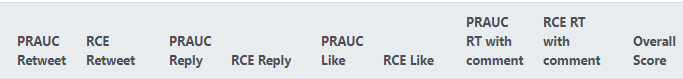

1.     model_list = [RUSBoostClassifier(),'',RUSBoostClassifier(),'']

2. prep_list = ['']*4

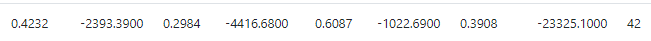
    
    

1. model_list = [RUSBoostClassifier(),'',RUSBoostClassifier(),'']

2. prep_list = ['']*4

3. train 1e6, val 1e5

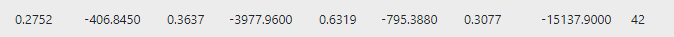


1. model_list = [RUSBoostClassifier(),'',RUSBoostClassifier(),'']

2. prep_list = ['']*4

3. train 1e6, val 1e5

4. using 'engaged_with_user_id' IT DOESNT FUCKING GO AS EXPECTED INITIALLY. NICE



In [12]:
train = {}
for i in range(4):
    train[i] = pd.read_pickle('train_{}.pkl'.format(i))

In [13]:
engagement = {}
label_list = ['reply','retweet', 'retweet_with_comment', 'like']

for i in range(len(label_list)):
    engagement[label_list[i]] = i
engagement

{'reply': 0, 'retweet': 1, 'retweet_with_comment': 2, 'like': 3}

# TRAIN

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

tt = TwitterTransform()
tt.fit(df_og)
x_train, y_train = tt.transform(df_og)

for label in label_list:
    print(label)
    idx = engagement[label]

    xgb = XGBClassifier()
    xgb.fit(x_train, y_train[:,idx])

    gt = {}
    pred = {}
    
    i=2
    x_val,y_val = tt.transform(train[i])
    gt[i] = y_val[:,idx]
    y_pred = xgb.predict(x_val)
#         y_pred = np.zeros(gt[i].shape)
    pred[i] = y_pred
    prauc = compute_prauc(pred[i], gt[i])
    rce = compute_rce(pred[i], gt[i])
    roc = roc_auc_score( gt[i],pred[i])
    print('{}>>> PRAUC:{:.4f} RCE:{:.4f} ROCAUC:{:.4f}'.format(i,prauc, rce, roc))

reply


In [19]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

tt = TwitterTransform()
tt.fit(df_og)
x_train, y_train = tt.transform(df_og)
x_val,y_val = tt.transform(train[0])

idx = engagement['like']
xgb = XGBClassifier()
xgb.fit(x_train, y_train[:,idx], eval_set=[(x_val, y_val[:,idx])], objective='binary:logistic', eval_metric='logloss')

np.unique( y_val[:,idx])

TypeError: fit() got an unexpected keyword argument 'objective'

In [30]:
for i in range(4):
    print_stats_df(train[i], name='Train_{}'.format(i))

GENERAL STATS Train_0
number of tweets: 1000000
number of unique media: 11
number of unique language: 65
number of unique EWUF users: 550983
number of unique EUF users: 857416

NUMBER OF ENGAGEMENTS Train_0
number of replies: 26725 0.026725
number of retweets: 111471 0.111471
number of retweet comments: 7577 0.007577
number of likes 438003 0.438003
------------------------------------------------------------

GENERAL STATS Train_1
number of tweets: 1000000
number of unique media: 10
number of unique language: 64
number of unique EWUF users: 552206
number of unique EUF users: 857431

NUMBER OF ENGAGEMENTS Train_1
number of replies: 26138 0.026138
number of retweets: 111214 0.111214
number of retweet comments: 7576 0.007576
number of likes 437455 0.437455
------------------------------------------------------------

GENERAL STATS Train_2
number of tweets: 1000000
number of unique media: 11
number of unique language: 64
number of unique EWUF users: 551302
number of unique EUF users: 85820

In [77]:
df = pd.read_pickle("train_2.pkl")

In [78]:
df.columns

Index(['text_ tokens', 'hashtags', 'tweet_id', 'present_media',
       'present_links', 'present_domains', 'tweet_type', 'language',
       'tweet_timestamp', 'engaged_with_user_id',
       'engaged_with_user_follower_count', 'engaged_with_user_following_count',
       'engaged_with_user_is_verified', 'engaged_with_user_account_creation',
       'enaging_user_id', 'enaging_user_follower_count',
       'enaging_user_following_count', 'enaging_user_is_verified',
       'enaging_user_account_creation', 'engagee_follows_engager',
       'reply_timestamp', 'retweet_timestamp',
       'retweet_with_comment_timestamp', 'like_timestamp'],
      dtype='object')

In [146]:
grouped = df.groupby(["enaging_user_id"]).agg({"enaging_user_follower_count": "mean"})
grouped

,enaging_user_follower_count
enaging_user_id,
617B49663373F607A9BEEDCAC8EB72D4,1339.0
617B4B570931E74EFA55E56F21C0F03C,212.0
617B50FA57962BEFB967E522290FCB61,180.0
617B52B304B8143A2047D21555CD38BC,344.0
617B5416240E311EE6EC5B339834E565,206.0
...,...
924FBBFBC73A6F11CBF1AE7B84199F58,134.0
924FBCAD5C8D85DC11021E47D4456E91,381.0
924FD0B26504F64F82EDD8263CAED63E,63.0


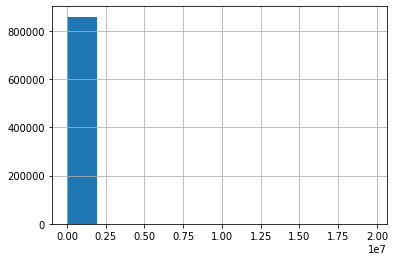

In [147]:
grouped["enaging_user_follower_count"].hist()

In [135]:
total = grouped.shape[0]
total

858209

In [154]:
filtered = grouped[grouped["enaging_user_follower_count"]<1e4]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1ba226850>]],
      dtype=object)

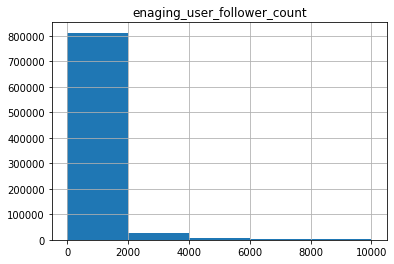

In [155]:
filtered.hist(bins=5)

In [93]:
hist, bins = np.histogram(filtered["engaged_with_user_follower_count"], bins=5)

In [102]:
bins

array([1.00000000e+00, 1.99984233e+05, 3.99967467e+05, 5.99950700e+05,
       7.99933933e+05, 9.99917167e+05])

In [100]:
for i in range(5):
    f = bins[i]
    t = bins[i+1]
    values = df["engaged_with_user_follower_count"]
    df["ew_follwer_bin_{}".format(i)] = np.where((f<=values) & (values<t), 1 ,0 )

In [101]:
cols = ["ew_follwer_bin_{}".format(i) for i in range(5)]
df[cols]

,ew_follwer_bin_0,ew_follwer_bin_1,ew_follwer_bin_2,ew_follwer_bin_3,ew_follwer_bin_4
0,1,0,0,0,0
1,0,0,1,0,0
2,1,0,0,0,0
3,0,0,0,0,0
4,1,0,0,0,0
...,...,...,...,...,...
999995,1,0,0,0,0
999996,0,1,0,0,0
999997,0,0,1,0,0
999998,1,0,0,0,0


In [ ]:
# group: engaged_with_user_id, engaged_with_user_follower_count, outlier 1e6
# group: engaged_with_user_id, engaged_with_user_following_count, outlier 1e4
# group: enaging_user_id, enaging_user_following_count, outlier 8e3
# group: enaging_user_id, enaging_user_follower_count, outlier 1e4

def following_class_group(df, group_column, follow_column, outlier, bins_count=5):
    grouped = df.groupby([group_column]).agg({follow_column: "mean"})
    filtered = grouped[grouped[follow_column]<outlier]
    hist, bins = np.histogram(filtered[follow_column], bins=bins_count)
    values = df[follow_column]                         
    for i in range(bins_count):
        f = bins[i]
        t = bins[i+1]
        df["ew_follwer_bin_{}".format(i)] = np.where((f<=values) & (values<t), 1 ,0 )